## Authorization Log Notebook

***
This notebook visualizes bot (Invalid user) attacks using an anonymized server log and IP address geolocation.  Bot
data is extracted from the log, geolocated with ipinfo, and put in a pandas dataframe.  Bot data is visualized
using histograms and a network graphs.  

Dataframe is archived to postgreSQL table linuxlog.  linuxlog is queried for Singapore and results saved to
singapore_df dataframe.
***

### Table of Contents:
* [Load and Wrangle Authorization Log](#first)
* [Visualize Bot Attacks](#second)
* [Move Data between Pandas and PostgreSQL](#third)
***

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipinfo  #IP address geolocation API
import re
import seaborn as sns

### Load and Wrangle Log <a class="anchor" id="first"></a>
***

In [2]:
#rawlog=pd.read_csv('Apr-2019/auth_log_2019_Apr28-May1.csv', sep=',,,', engine='python')
rawlog=pd.read_csv('Apr-2019/auth_log_2019_Apr28-May1.csv')
rawlog.drop(['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'], axis=1, inplace=True, errors='ignore')
pd.set_option('max_colwidth', 1000)
rawlog=rawlog.rename(columns={"auth.log_Apr28-May1": "linlog"})

In [3]:
print('Bracked numbers are PIDs that stick while connection lives:')
rawlog.head()

Bracked numbers are PIDs that stick while connection lives:


,linlog
0,Apr 28 06:25:02 hostpc CRON[8881]: pam_unix(cron:session): session closed for user root
1,Apr 28 06:25:24 hostpc sshd[9006]: Invalid user test from 31.13.32.186 port 36196
2,"Apr 28 06:25:24 hostpc sshd[9006]: Received disconnect from 31.13.32.186 port 36196:11: Normal Shutdown, Thank you for playing [preauth]"
3,Apr 28 06:25:24 hostpc sshd[9006]: Disconnected from invalid user test 31.13.32.186 port 36196 [preauth]
4,Apr 28 06:39:01 hostpc CRON[9112]: pam_unix(cron:session): session opened for user root by (uid=0)


In [4]:
#get token to access ip details
fileObj = open('Apr-2019/token_for_ip.txt','r')
tok=fileObj.read()

In [5]:
rawlog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 1 columns):
linlog    4521 non-null object
dtypes: object(1)
memory usage: 35.4+ KB


In [6]:
#Reduce number of records
cleanlog=rawlog.iloc[0:300]

In [7]:
#Flag 'Invalid user' rows
filter=cleanlog['linlog'].str.find(': Invalid user')
print('Rows meeting criteria are greater than zero:')
cleanlog=cleanlog[(filter>0)]

#Add location features to dataframe
cleanlog['ip']=np.NaN
cleanlog['city']=np.NaN
cleanlog['region']=np.nan
cleanlog['country']=np.nan
cleanlog['loc']=np.nan
cleanlog['postal']=np.nan
cleanlog['org']=np.nan
cleanlog['country_name']=np.nan
cleanlog['ip_address']=np.nan
cleanlog['latitude']=np.nan
cleanlog['longitude']=np.nan

cleanlog.head(3)

Rows meeting criteria are greater than zero:


,linlog,ip,city,region,country,loc,postal,org,country_name,ip_address,latitude,longitude
1,Apr 28 06:25:24 hostpc sshd[9006]: Invalid user test from 31.13.32.186 port 36196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Apr 28 06:44:05 hostpc sshd[9115]: Invalid user manager from 159.89.121.126 port 53486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Apr 28 06:47:49 hostpc sshd[9139]: Invalid user icandb from 123.206.13.46 port 49112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Extract IP -- we will fetch location using the IP

#Credit for clever regex pattern to extract ip
#https//superuser.com/questions/1321363/how-to-extract-ip-address-from-the-logs-string-with-regular-expression-and-note

#  ^        -- beginning of line
#  .+?      -- 1 or more any character but newline
#  from\s   -- added from with single space matching bc my auth.log always has "from " before the ip
#  (        -- start group 1
#  (?:      -- start non-capture group of characters
#  \d+      -- 1 or more digit
#  \.       -- a dot
#  ){3}     -- end group, must appear 3 times
#  \d+      -- 1 or more digit
#  )        -- end group 1
#  .+       -- 1 or more any character but newline
#  $        -- end of line

patt="^.+?from\s((?:\d+\.){3}\d+).+$"
ip_extract=cleanlog['linlog'].str.extract(patt)

#Add meaningful column name to extract
ip_extract.columns=['IP_Addr']

In [9]:
ip_extract.head(3)

,IP_Addr
1,31.13.32.186
6,159.89.121.126
11,123.206.13.46


In [10]:
#Get IP detail in handler object
handler=ipinfo.getHandler(tok)

#Seed dictionary with locations using ip_extract
location_dict={}
for idx, ip in ip_extract['IP_Addr'].iteritems():     #make ip_extract a Series
    location_dict[idx]=handler.getDetails(ip).all

In [11]:
#Seed dataframe using dictionary locations
for index, row in cleanlog.iterrows():
    for c in ['ip','city', 'region','country','loc','postal','org','country_name','ip_address','latitude','longitude']:
        try:
            cleanlog.loc[index, c]=location_dict[index][c]
        except:
            #print('Value missing for','index:',index,';', ' col:', c)
            pass
        
#Seed dataframe with invalid user <user> from auth.log column
patt="^.+?user\s(.+?)\sfrom"
invalid_user=cleanlog['linlog'].str.extract(patt)
invalid_user.columns=['user']
cleanlog['inval_user']=invalid_user
cleanlog.head(2)        

print('cleanlog row count:', len(cleanlog))

cleanlog row count: 72


In [12]:
#Convert long/lat to float
for c in ['latitude', 'longitude']:
    cleanlog[c]=cleanlog[c].astype('float')
    
#Insert a counts column - for country_name as string
#Tranform returns shape the same as original. 'size' includes NaNs.
cleanlog['location_cnt']=cleanlog.groupby(by=['country_name'])['ip'].transform('size')
cleanlog['location_cnt_float']=cleanlog['location_cnt'].astype('float')             #integer column
cleanlog['location_cnt']=cleanlog['location_cnt'].astype('str')                     #string column

In [13]:
cleanlog.head(2)

,linlog,ip,city,region,country,loc,postal,org,country_name,ip_address,latitude,longitude,inval_user,location_cnt,location_cnt_float
1,Apr 28 06:25:24 hostpc sshd[9006]: Invalid user test from 31.13.32.186 port 36196,31.13.32.186,Moscow,Moscow City,RU,"55.7520,37.6150",117535,AS8732 OJSC Comcor,Russia,31.13.32.186,55.7520,37.6150,test,1,1.0
6,Apr 28 06:44:05 hostpc sshd[9115]: Invalid user manager from 159.89.121.126 port 53486,159.89.121.126,Toronto,Ontario,CA,"43.6555,-79.3626",M5A,"AS14061 DigitalOcean, LLC",Canada,159.89.121.126,43.6555,-79.3626,manager,1,1.0


### Visualize Bot Attacks <a class="anchor" id="second"></a>
***

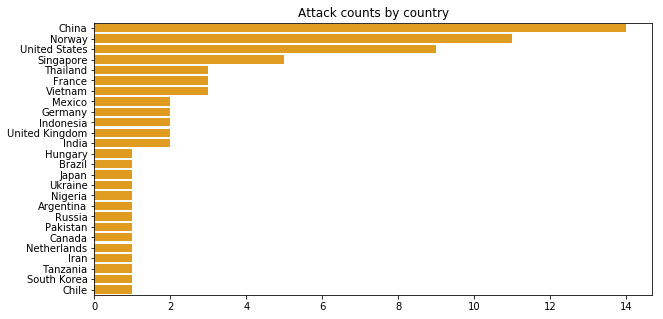

In [14]:
#Where are attacks from?

#Use sorted histogram-style data in barplot
x_vals=cleanlog['country_name'].value_counts().values     #labels
y_vals=cleanlog['country_name'].value_counts().index      #counts

fig, ax=plt.subplots(figsize=(10,5))
sns.barplot(x=x_vals, y=y_vals,data=cleanlog, ax=ax, color='orange')
ax.set_title('Attack counts by country')
plt.show()

In [15]:
#NEW CODE HERE

#replace all dataframe commas with semicolons.  will allow parsing dataframe into postgre table using comma delimiter.
cleanlog.replace(',',';', inplace=True, regex=True)

#Replace blank city names with 'Unavailable'
scrub_dict={'city' : {'' : 'Unavailable'}}
cleanlog.replace(scrub_dict, inplace=True) 
cleanlog['city'].unique()

array(['Moscow', 'Toronto', 'Beijing', 'Santa María Tequepexpan',
       'Unavailable', 'Singapore', 'Yuanlong', 'Provo', 'Roubaix',
       'Amsterdam', 'Kyiv', 'Jayapura', 'Isfahan', 'North Bergen',
       'Santiago', 'Buenos Aires', 'Jakarta', 'Little Rock', 'Bergen',
       'Clifton', 'Bangalore', 'Lahore', 'Chengdu', 'Cau Giay',
       'Guadalupe', 'Las Vegas', 'Kansas City', 'Conselheiro Lafaiete',
       'Pekin', 'Frankfurt', 'London', 'Horb am Neckar'], dtype=object)

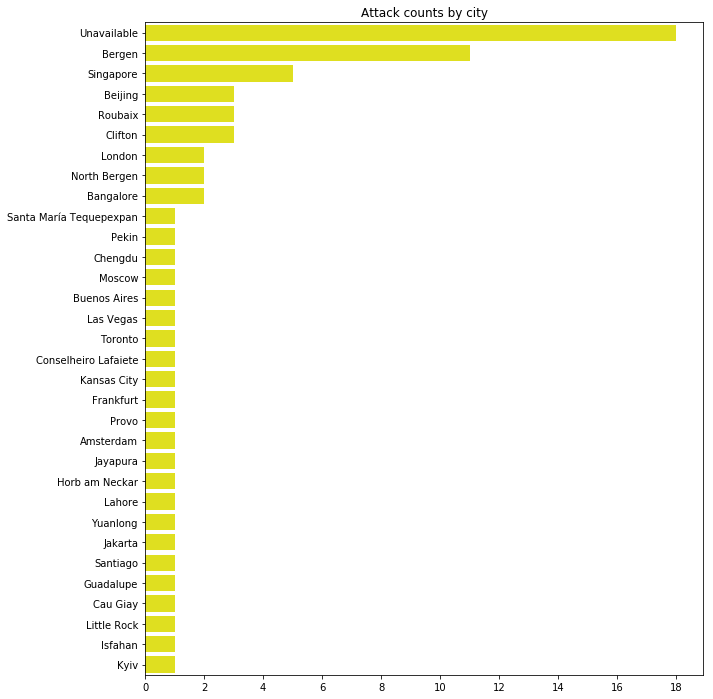

In [16]:
#Where are attacks from?

from matplotlib.ticker import MaxNLocator #select no more than N intervals at nice locations

#Use sorted histogram-style data in barplot
x_vals=cleanlog['city'].value_counts().values     #labels
y_vals=cleanlog['city'].value_counts().index      #counts

fig, ax=plt.subplots(figsize=(10,12))
sns.barplot(x=x_vals, y=y_vals,data=cleanlog, ax=ax, color='yellow')
ax.set_title('Attack counts by city')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  #make xaxis integers
plt.show()

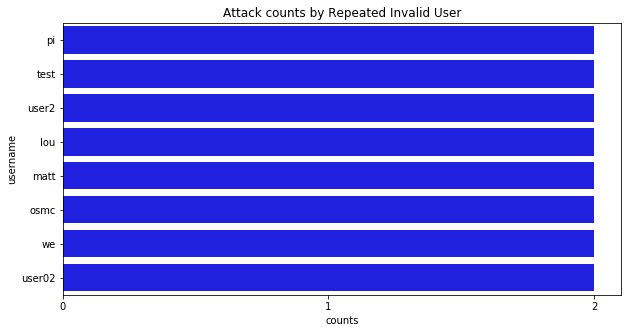

In [17]:
#Plot Invalid Username frequency

#create df with username and username counts
dic={'username': cleanlog['inval_user'].value_counts().index, 'counts': cleanlog['inval_user'].value_counts().values}
userdf=pd.DataFrame(data=dic)

#Filter for counts more than 1
userdf=userdf[userdf['counts']>1]

fig, ax=plt.subplots(figsize=(10,5))
sns.barplot(x=userdf['counts'], y=userdf['username'],data=cleanlog, ax=ax, color='b')
ax.set_title('Attack counts by Repeated Invalid User')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  #make xaxis integers
plt.show()

In [18]:
cleanlog.head(1)

,linlog,ip,city,region,country,loc,postal,org,country_name,ip_address,latitude,longitude,inval_user,location_cnt,location_cnt_float
1,Apr 28 06:25:24 hostpc sshd[9006]: Invalid user test from 31.13.32.186 port 36196,31.13.32.186,Moscow,Moscow City,RU,55.7520;37.6150,117535,AS8732 OJSC Comcor,Russia,31.13.32.186,55.752,37.615,test,1,1.0


Note:  If there are multiple IPs in a country, the IP locations are plotted as red circles.
However, countries are only labeled once.


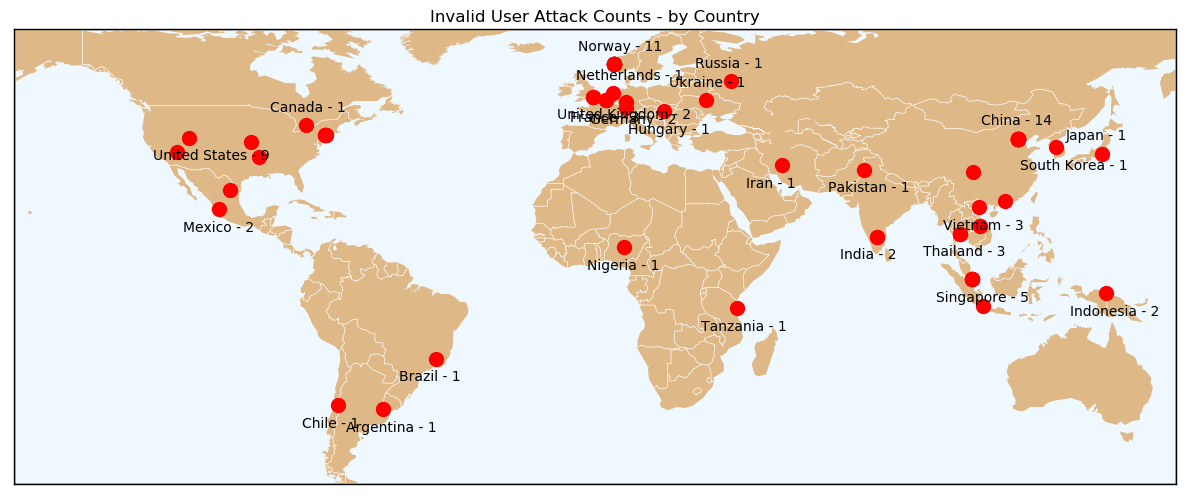

In [19]:
# import mapping libraries
from mpl_toolkits.basemap import Basemap

#Initialize map boundaries
#https://python-graph-gallery.com/286-boundaries-provided-in-basemap/
plt.figure(figsize=(15,10), dpi=100)
map = Basemap(llcrnrlon=-160, llcrnrlat=-55,urcrnrlon=160,urcrnrlat=70)

#Color codes:  https://matplotlib.org/2.0.2/examples/color/named_colors.html
# Continent and countries
map.drawmapboundary(fill_color='aliceblue')
map.fillcontinents(color='burlywood',lake_color='burlywood')
map.drawcountries(color="white")
 
#plot    
lons = cleanlog['longitude']  #east-west position of a point
lats = cleanlog['latitude']   #north-south position of a point
x,y = map(lons, lats)
#'ro' is red circle markers. https://matplotlib.org/api/markers_api.html#module-matplotlib.markers
map.plot(x, y, 'ro', markersize=10)  
plt.title('Invalid User Attack Counts - by Country')

###########################################
#Plot one IP per country or all IPs??     #
###########################################

already_plotted=[]
for index, (country_name, location_cnt, x, y) in cleanlog[['country_name', 'location_cnt','longitude','latitude']].iterrows():
    if country_name in already_plotted:  #skip current iteration ONLY
        continue    
    if country_name in ['Canada','Russia','China','Netherlands','Ukraine','Seychelles', 'Japan','Norway']:
        plt.text(x-10, y+4, country_name+' - '+location_cnt)         
    else:
        plt.text(x-10, y-6, country_name+' - '+location_cnt)
    already_plotted.append(country_name)
    
print('Note:  If there are multiple IPs in a country, the IP locations are plotted as red circles.')    
print('However, countries are only labeled once.')          


          ################## Countries linked to invalid usernames: ##################


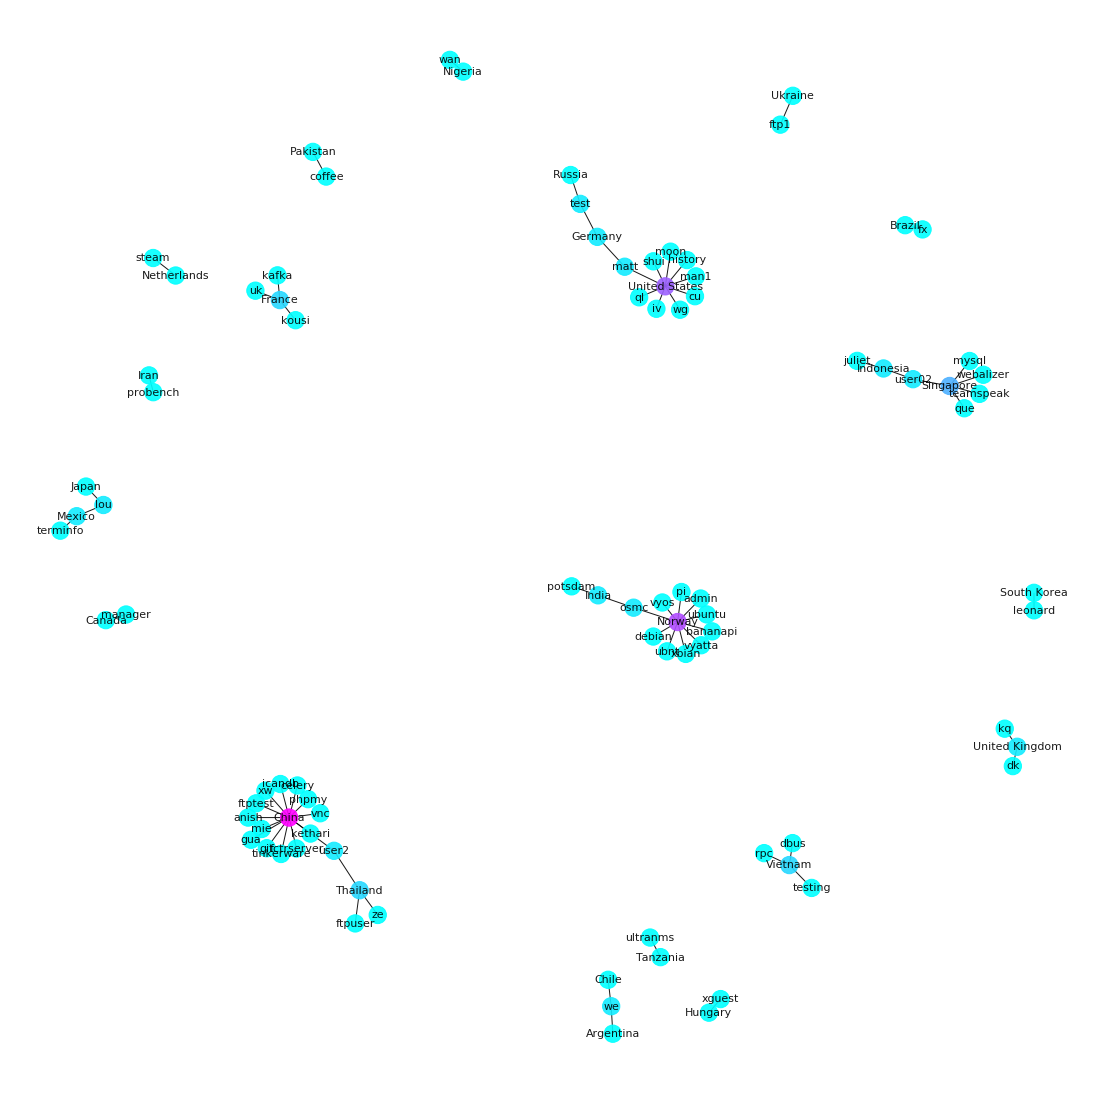

In [20]:
import networkx as nx
    
origins=cleanlog['country_name']
names=cleanlog['inval_user']
#Create networkx graph
G=nx.Graph()
pos = nx.circular_layout(G)

#Add nodes
for origin in origins:
    G.add_node(origin)  
for name in names:
    G.add_node(name)
    
#Add edges    
for row in cleanlog.itertuples():
    G.add_edge(row.country_name, row.inval_user)
    
#Plot network with node color changing with node degree/frequency
#cmaps: https://matplotlib.org/tutorials/colors/colormaps.html
plt.figure(figsize=(15,15))
node_color=[G.degree(origin) for origin in G]
nx.draw(G, with_labels=True, font_size=11, node_color=node_color, alpha=0.9,cmap=plt.cm.cool)
print('\n','         ################## Countries linked to invalid usernames: ##################')

In [21]:
user_piv=cleanlog.pivot_table(index=['country_name'], values=['inval_user'], aggfunc='count')
user_piv=user_piv.sort_values(by='inval_user',axis=0, ascending=False)   #col sort
print('Countries with multiple invalid users:')
user_piv=user_piv[user_piv['inval_user']>1]
user_piv

Countries with multiple invalid users:


,inval_user
country_name,
China,14
Norway,11
United States,9
Singapore,5
Vietnam,3
France,3
Thailand,3
United Kingdom,2
Germany,2


In [22]:
print('Alphabetical country_name and invalid user detail:')
cleanlog[['country_name', 'inval_user']].sort_values(by=['country_name']).head(15)

Alphabetical country_name and invalid user detail:


,country_name,inval_user
111,Argentina,we
261,Brazil,fx
6,Canada,manager
108,Chile,we
80,China,xw
65,China,git
58,China,tinkerware
270,China,ftptest
183,China,anish
264,China,celery


### Move Data between Pandas and PostgreSQL <a class="anchor" id="third"></a>
***

In [23]:
#initialize Checkbox object
from IPython.display import display
from ipywidgets import Checkbox, interact

box=Checkbox(value=True, description='Check to archive cleanlog', disabled=False)  #default Checkbox to FALSE

In [24]:
#Show Checkbox and save value
display(box)
archive_switch=box.value  #Check box to archive to PostgreSQL database

Checkbox(value=True, description='Check to archive cleanlog')

In [25]:
#cur.execute("DROP TABLE linuxlog")

In [26]:
if archive_switch==True:
    
    #INSTANTIATE - Launch Postgre database and create table.

    #Note1: Postgre Server installed locally and set to manual Start.  Start with Services>PostgreSQL Server>Start
    #Note2: to create new database, PostgreSQL command line tool, psql, connects to running server.

    import psycopg2  #import PostgreSQL Python client
    import io

    #connect to database by running context manager and using default db name/user
    conn=psycopg2.connect("dbname=postgres user=postgres host=localhost")   
    conn.autocommit=True  #automatically commit changes
    cur=conn.cursor()  #create database instance

    #Set time zone for postgre server
    cur.execute("SET timezone = 'America/Chicago'")
    #cur.execute("SHOW timezone")

    #Create 'linuxlog' database.  SERIAL auto-increments the id.  'default current_timestamp' adds timestamp for timezone.
    create_linuxlog='''
                    CREATE TABLE IF NOT EXISTS linuxlog(
                    id SERIAL PRIMARY KEY,
                    time_stamp timestamptz default current_timestamp,
                    linlog varchar(1024),
                    ip varchar(80),
                    city varchar(80),
                    region varchar(80),
                    country varchar(16),
                    loc varchar(80),
                    postal varchar(10),
                    org varchar(80),
                    country_name varchar(80),
                    ip_address varchar(80),
                    latitude float,
                    longitude varchar(80),
                    location_cnt int,
                    location_cnt_float float,
                    inval_user varchar(80))
                    '''
    #create Postgre table 'linuxlog'
    cur.execute(create_linuxlog)

    #display table attributes
    cur.execute("SELECT column_name, data_type FROM information_schema.columns WHERE table_name='linuxlog'")
    print('Table attributes:\n', cur.fetchall())

    #time the append operation
    import time
    start=time.time()

    #ARCHIVE - append dataframe to Postgre table.

    #import certain dataframe columns to postgre table
    df_cols=['linlog','ip','city','region','country','loc','postal','org','country_name','ip_address','latitude','longitude','location_cnt','location_cnt_float','inval_user']
    import_cols=('linlog','ip','city','region','country','loc','postal','org','country_name','ip_address','latitude','longitude','location_cnt','location_cnt_float','inval_user')

    f = io.StringIO()  #in-memory stream for text I/O
    cleanlog[df_cols].to_csv(f, index=False, header=False)  # write csv (ex-index) to f.
    f.seek(0)  # move position to beginning of file before reading

    cur.copy_from(f, 'linuxlog', columns=import_cols, sep=',')   #read comma-delimited data from f and append to table
    #cur.execute("select * from linuxlog;")
    #cur.fetchall()

    end=time.time()
    print('\n','#### Posgre database import time:', end-start, '####')
else:
    print('#### Archiving to postgre is OFF   ####')


Table attributes:
 [('id', 'integer'), ('time_stamp', 'timestamp with time zone'), ('linlog', 'character varying'), ('ip', 'character varying'), ('city', 'character varying'), ('region', 'character varying'), ('country', 'character varying'), ('loc', 'character varying'), ('postal', 'character varying'), ('org', 'character varying'), ('country_name', 'character varying'), ('ip_address', 'character varying'), ('latitude', 'double precision'), ('longitude', 'character varying'), ('location_cnt', 'integer'), ('location_cnt_float', 'double precision'), ('inval_user', 'character varying')]

 #### Posgre database import time: 0.015592336654663086 ####


In [27]:
#Select data in table: linuxlog

print('#### linuxlog queried for country_name=Singapore: ####','\n')

#cur.execute("DROP TABLE linuxlog")
if archive_switch==True:
    query1='''SELECT * from linuxlog WHERE country_name='Singapore';'''
    cur.execute(query1)
    display(cur.fetchall())
    print(type(cur.fetchall()))
else:
    print('\'cleanlog\' dataframe isn\'t archived to postgres.  Check the checkbox above to archive.')

#### linuxlog queried for country_name=Singapore: #### 



[(6,
  datetime.datetime(2019, 5, 7, 13, 41, 24, 847115, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-300, name=None)),
  'Apr 28 06:50:31 hostpc sshd[9146]: Invalid user webalizer from 159.65.135.55 port 50712',
  '159.65.135.55',
  'Singapore',
  'SINGAPORE',
  'SG',
  '1.2931;103.8560',
  '',
  'AS14061 DigitalOcean; LLC',
  'Singapore',
  '159.65.135.55',
  1.2931,
  '103.856',
  5,
  5.0,
  'webalizer'),
 (14,
  datetime.datetime(2019, 5, 7, 13, 41, 24, 847115, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-300, name=None)),
  'Apr 28 07:17:46 hostpc sshd[9205]: Invalid user user02 from 128.199.123.170 port 41332',
  '128.199.123.170',
  'Singapore',
  'SINGAPORE',
  'SG',
  '1.2931;103.8560',
  '',
  'AS14061 DigitalOcean; LLC',
  'Singapore',
  '128.199.123.170',
  1.2931,
  '103.856',
  5,
  5.0,
  'user02'),
 (25,
  datetime.datetime(2019, 5, 7, 13, 41, 24, 847115, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-300, name=None)),
  'Apr 28 07:57:17 hostpc sshd[9259]: Invalid 

<class 'list'>


In [28]:
#Read PostgreSQL query into dataframe
def insert_sql_into_df(select_query):
    conn=psycopg2.connect("dbname=postgres user=postgres host=localhost")   #connect to db with default db name/user
    cur=conn.cursor()  #create database instance    
    fstore=io.StringIO()   #in-memory stream for text I/O
    sql_copy="COPY ("+select_query+") TO STDOUT WITH (FORMAT CSV, HEADER);"  #concatenate in the query
    cur.copy_expert(sql_copy, fstore)  #write copy_sql to fstore
    fstore.seek(0)  # move position to beginning of file before reading
    df=pd.read_csv(fstore)   #read fstore data into csv
    return df

query="SELECT * FROM linuxlog WHERE country_name='Singapore'"
singapore_df=insert_sql_into_df(select_query=query)
print('Singapore query results are stored in singapore_df dataframe.')
singapore_df

Singapore query results are stored in singapore_df dataframe.


,id,time_stamp,linlog,ip,city,region,country,loc,postal,org,country_name,ip_address,latitude,longitude,location_cnt,location_cnt_float,inval_user
0,6,2019-05-07 13:41:24.847115-05,Apr 28 06:50:31 hostpc sshd[9146]: Invalid user webalizer from 159.65.135.55 port 50712,159.65.135.55,Singapore,SINGAPORE,SG,1.2931;103.8560,NaN,AS14061 DigitalOcean; LLC,Singapore,159.65.135.55,1.2931,103.856,5,5,webalizer
1,14,2019-05-07 13:41:24.847115-05,Apr 28 07:17:46 hostpc sshd[9205]: Invalid user user02 from 128.199.123.170 port 41332,128.199.123.170,Singapore,SINGAPORE,SG,1.2931;103.8560,NaN,AS14061 DigitalOcean; LLC,Singapore,128.199.123.170,1.2931,103.856,5,5,user02
2,25,2019-05-07 13:41:24.847115-05,Apr 28 07:57:17 hostpc sshd[9259]: Invalid user que from 159.65.4.50 port 33457,159.65.4.50,Singapore,SINGAPORE,SG,1.2931;103.8560,NaN,AS14061 DigitalOcean; LLC,Singapore,159.65.4.50,1.2931,103.856,5,5,que
3,59,2019-05-07 13:41:24.847115-05,Apr 28 08:54:52 hostpc sshd[9426]: Invalid user mysql from 128.199.106.169 port 45988,128.199.106.169,Singapore,SINGAPORE,SG,1.2931;103.8560,NaN,AS14061 DigitalOcean; LLC,Singapore,128.199.106.169,1.2931,103.856,5,5,mysql
4,64,2019-05-07 13:41:24.847115-05,Apr 28 09:21:17 hostpc sshd[9452]: Invalid user teamspeak from 178.128.112.98 port 35940,178.128.112.98,Singapore,SINGAPORE,SG,1.2931;103.8560,NaN,AS14061 DigitalOcean; LLC,Singapore,178.128.112.98,1.2931,103.856,5,5,teamspeak


In [30]:
#By Justin Mackie
#LinkedIn:  https://www.linkedin.com/in/justinmackie/
#GitHub Data Science Projects:  https://github.com/jkmackie